In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from platform import python_version
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as T
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.animation as animation
from IPython.display import HTML

In [2]:
import PIL
from tqdm import tqdm
from torch.utils.data import  DataLoader, Dataset
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid

In [4]:
!pip install wget

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for wget: started
  Running setup.py install for wget: finished with status 'done'


  DEPRECATION: wget is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [43]:
origin_file_path = "data/origin"
test_folder, train_folder = "data/test_data", "data/train_data"
n_epochs = 15
batch_size = 16
# adam:
lr = 0.00008
b1 = 0.5
b2 = 0.999

default_img_size = (128, 128)
default_mask_size = (64, 64)
channels = 3
sample_interval = 500

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
os.makedirs("images", exist_ok=True)
os.makedirs("saved_models", exist_ok=True)

# Calculate output dims of image discriminator (PatchGAN)
patch_h, patch_w = int(default_mask_size[1] / 2 ** 3), int(default_mask_size[0] / 2 ** 3)
patch = (1, patch_h, patch_w)

## Data Preparation
Downloading the dataset from http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped%20images/part2.zip, this might take several minutes since the dataset is about 5 GB. Then unzip the file.

In [ ]:
import wget
import zipfile

files = ["part1.zip", "part2.zip"]
for down_file in tqdm(files):
    url = f"http://www.cs.ucf.edu/~aroshan/index_files/Dataset_PitOrlManh/zipped images/{down_file}"
    filename = wget.download(url)
    print(filename)

    with zipfile.ZipFile(filename,"r") as zip_ref:
        zip_ref.extractall(origin_file_path)

In [59]:
# import cv2
# masked_file_path = "masked"
# if not os.path.exists(masked_file_path):
#     os.mkdir(masked_file_path)

# for image_file in tqdm(os.listdir(origin_file_path)):
#     input_path = os.path.join(origin_file_path, image_file)
#     if not os.path.isfile(input_path):
#         print(f"{input_path} is not a file, skipping...")
#         continue
#     img = PIL.Image.open(input_path)
#     img_ary = np.array(img, dtype=np.uint8)
#     center = (640, 512)
#     width, height = 400, 300
#     startx, starty = center[0] - width//2, center[1] - height//2
#     img_ary[starty:starty+height, startx:startx+width, :] = 0
#     PIL.Image.fromarray(img_ary).save(os.path.join(masked_file_path, image_file))

100%|██████████| 6600/6600 [01:50<00:00, 59.71it/s]


We will partition the file into test and train dataset, and then copy them into corresponding test and train folder.

In [19]:
import shutil
file_list = [x for x in os.listdir(origin_file_path) if os.path.isfile(os.path.join(origin_file_path, x))]
file_list.sort()
file_list = np.array(file_list)
train_length = len(file_list) * 4 // 5
# For reproducible purposes
np.random.seed(0)
train_indices = np.random.choice(len(file_list), train_length, replace = False)
train_mask = np.zeros(file_list.shape, dtype=bool)
train_mask[train_indices] = True

if os.path.exists(test_folder):
    shutil.rmtree(test_folder)
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

os.mkdir(test_folder)
os.mkdir(train_folder)

for train_file in tqdm(file_list[train_mask]):
    shutil.copyfile(os.path.join(origin_file_path, train_file), os.path.join(train_folder, train_file))
for test_file in tqdm(file_list[~train_mask]):
    shutil.copyfile(os.path.join(origin_file_path, test_file), os.path.join(test_folder, test_file))

100%|██████████| 1320/1320 [00:01<00:00, 692.23it/s]


In [22]:
def apply_mask(img, mask_size, random=True):
    """
    Randomly masks image
    Img: tensor
    maske_size: tuple, (W, H)
    random: boolean, False means center crop
    """
    if not torch.is_tensor(img):
        raise TypeError("Only tensors are allowed")
    channel, y, x = img.size()
    
    y1, x1 = (y - mask_size[1]) // 2, (x - mask_size[0]) // 2
    if random:
        y1, x1 = np.random.randint(0, y - mask_size[1]), np.random.randint(0, x - mask_size[0])
    y2, x2 = y1 + mask_size[1], x1 + mask_size[0]
    masked_part = img[:, y1:y2, x1:x2]
    masked_img = img.clone()
    masked_img[:, y1:y2, x1:x2] = 1

    return masked_img, masked_part, (y1, x1)

As a demonstration, we verify our mask application funciton works:

(1280, 1024)


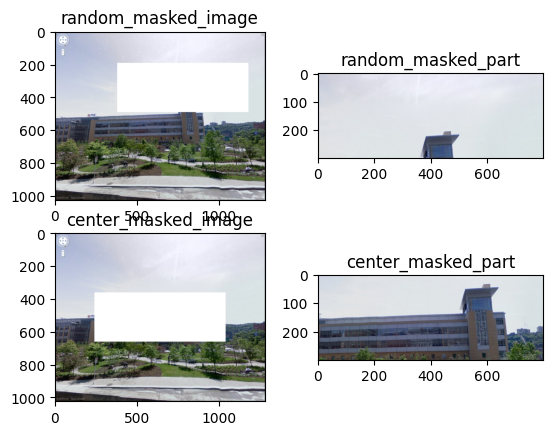

In [35]:
input_path = os.path.join(origin_file_path, "001100_1.jpg")
img = PIL.Image.open(input_path)
print(img.size)
img = T.ToTensor()(img)


test_mask_size = (800, 300)
random_masked_img, random_masked_part, _ = apply_mask(img, test_mask_size, True)

center_masked_img, center_masked_part, _ = apply_mask(img, test_mask_size, False)

fig = plt.figure()
plt.subplot(221)
plt.title("random_masked_image")
plt.imshow(random_masked_img.permute(1, 2, 0))
plt.subplot(222)
plt.title("random_masked_part")
plt.imshow(random_masked_part.permute(1, 2, 0))
plt.subplot(223)
plt.title("center_masked_image")
plt.imshow(center_masked_img.permute(1, 2, 0))
plt.subplot(224)
plt.title("center_masked_part")
plt.imshow(center_masked_part.permute(1, 2, 0))

# PIL.Image.fromarray(img_ary).save(os.path.join(masked_file_path, image_file))

In [38]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, mask_size=default_mask_size, train=True):
        self.transform = T.Compose(transforms_)
        self.mask_size = mask_size
        self.train = train
        self.files = sorted([os.path.join(root, x) for x in os.listdir(root) if os.path.isfile(os.path.join(root, x))])


    def __getitem__(self, index):
        img = PIL.Image.open(self.files[index % len(self.files)])
        img = self.transform(img)

        # Use random crop if we are in train mode
        masked_img, masked_part, lefttop_corner = apply_mask(img, self.mask_size, random=self.train)

        return img, masked_img, masked_part, lefttop_corner

    def __len__(self):
        return len(self.files)

In [39]:
transforms_ = [
    T.Resize(default_img_size, PIL.Image.BICUBIC),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]
dataloader = DataLoader(
    ImageDataset(train_folder, transforms_=transforms_),
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)
test_dataloader = DataLoader(
    ImageDataset(test_folder, transforms_=transforms_, train=False),
    batch_size=12,
    shuffle=False,
    num_workers=0,
)

c:\Users\KandaMaya\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\transforms.py:332: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [61]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2),
        )

        self.connection = nn.Conv2d(512, 4000, 1)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4000, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512, 0.8),
            nn.ELU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.BatchNorm2d(256, 0.8),
            nn.ELU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.ELU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.ELU(),
        )

        self.upsampler = nn.Sequential(
            nn.Conv2d(64, channels, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        output = self.encoder(x)
        output = self.connection(output)
        output = self.decoder(output)
        output = self.upsampler(output)

        return output


class Discriminator(nn.Module):
    def __init__(self, channels=3):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(channels, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 3, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 3, stride=1, padding=1),
        )

    def forward(self, img):
        return self.model(img)

In [62]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

def save_sample(batches_done):
    samples, masked_samples, _, (y1, x1) = next(iter(test_dataloader))
    mask_w, mask_h = test_dataloader.dataset.mask_size
    samples = Variable(samples.type(Tensor))
    masked_samples = Variable(masked_samples.type(Tensor))
    y1 = y1[0].item()
    x1 = x1[0].item()
    # Generate inpainted image
    gen_mask = generator(masked_samples)
    filled_samples = masked_samples.clone()
    filled_samples[:, :, y1 : y1 + mask_w, x1 : x1 + mask_h] = gen_mask
    # Save sample
    sample = torch.cat((masked_samples.data, filled_samples.data, samples.data), -2)
    save_image(sample, os.path.join("images", f"{batches_done}.png") , nrow=6, normalize=True)

# Loss function
adversarial_loss = torch.nn.MSELoss()
pixelwise_loss = torch.nn.L1Loss()

# Initialize generator and discriminator
generator = Generator(channels=channels)
discriminator = Discriminator(channels=channels)

generator.to(device)
discriminator.to(device)
adversarial_loss.to(device)
pixelwise_loss.to(device)

# Initialize weights
generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

In [63]:
gen_adv_losses, gen_pixel_losses, disc_losses, counter = [], [], [], []

for epoch in range(n_epochs):
    
    ### Training ###
    gen_adv_loss, gen_pixel_loss, disc_loss = 0, 0, 0
    tqdm_bar = tqdm(dataloader, desc=f'Training Epoch {epoch} ', total=int(len(dataloader)))
    for i, data in enumerate(tqdm_bar):
        imgs, masked_imgs, masked_parts, _ = data
        # Adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], *patch).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], *patch).fill_(0.0), requires_grad=False)
        # Configure input
        imgs = Variable(imgs.type(Tensor))
        masked_imgs = Variable(masked_imgs.type(Tensor))
        masked_parts = Variable(masked_parts.type(Tensor))

        ## Train Generator ##
        optimizer_G.zero_grad()

        # Generate a batch of images
        gen_parts = generator(masked_imgs)
        # Adversarial and pixelwise loss
        g_adv = adversarial_loss(discriminator(gen_parts), valid)
        g_pixel = pixelwise_loss(gen_parts, masked_parts)
        # Total loss
        g_loss = 0.001 * g_adv + 0.999 * g_pixel

        g_loss.backward()
        optimizer_G.step()

        ## Train Discriminator ##
        optimizer_D.zero_grad()

        # Measure discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(masked_parts), valid)
        fake_loss = adversarial_loss(discriminator(gen_parts.detach()), fake)
        d_loss = 0.5 * (real_loss + fake_loss)

        d_loss.backward()
        optimizer_D.step()
        
        gen_adv_loss, gen_pixel_loss, disc_loss
        gen_adv_losses, gen_pixel_losses, disc_losses, counter
        
        gen_adv_loss += g_adv.item()
        gen_pixel_loss += g_pixel.item()
        gen_adv_losses.append(g_adv.item())
        gen_pixel_losses.append(g_pixel.item())
        disc_loss += d_loss.item()
        disc_losses.append(d_loss.item())
        counter.append(i*batch_size + imgs.size(0) + epoch*len(dataloader.dataset))
        tqdm_bar.set_postfix(gen_adv_loss=gen_adv_loss/(i+1), gen_pixel_loss=gen_pixel_loss/(i+1), disc_loss=disc_loss/(i+1))
        
        # Generate sample at sample interval
        batches_done = epoch * len(dataloader) + i
        if batches_done % sample_interval == 0:
            save_sample(batches_done)
            

Training Epoch 0 :   0%|          | 0/330 [00:00<?, ?it/s]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   0%|          | 0/330 [00:00<?, ?it/s, disc_loss=0.695, gen_adv_loss=0.746, gen_pixel_loss=0.446]

0


Training Epoch 0 :   1%|          | 2/330 [00:01<02:39,  2.06it/s, disc_loss=0.713, gen_adv_loss=0.943, gen_pixel_loss=0.448]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   1%|          | 3/330 [00:01<02:04,  2.62it/s, disc_loss=0.61, gen_adv_loss=0.86, gen_pixel_loss=0.447]  

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   1%|          | 4/330 [00:01<01:49,  2.99it/s, disc_loss=0.547, gen_adv_loss=0.849, gen_pixel_loss=0.46]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   2%|▏         | 5/330 [00:01<01:41,  3.21it/s, disc_loss=0.492, gen_adv_loss=0.818, gen_pixel_loss=0.466]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   2%|▏         | 6/330 [00:02<01:36,  3.37it/s, disc_loss=0.448, gen_adv_loss=0.799, gen_pixel_loss=0.478]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   2%|▏         | 7/330 [00:02<01:36,  3.35it/s, disc_loss=0.411, gen_adv_loss=0.786, gen_pixel_loss=0.48] 

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   2%|▏         | 8/330 [00:02<01:35,  3.38it/s, disc_loss=0.381, gen_adv_loss=0.778, gen_pixel_loss=0.482]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


Training Epoch 0 :   3%|▎         | 9/330 [00:03<01:50,  2.91it/s, disc_loss=0.358, gen_adv_loss=0.771, gen_pixel_loss=0.483]

+++++++++++++++++++++++++
torch.Size([16, 1, 8, 8])
torch.Size([16, 3, 64, 64])


KeyboardInterrupt: 

In [ ]:
torch.save(generator.state_dict(), "saved_models/generator.pth")
torch.save(discriminator.state_dict(), "saved_models/discriminator.pth")

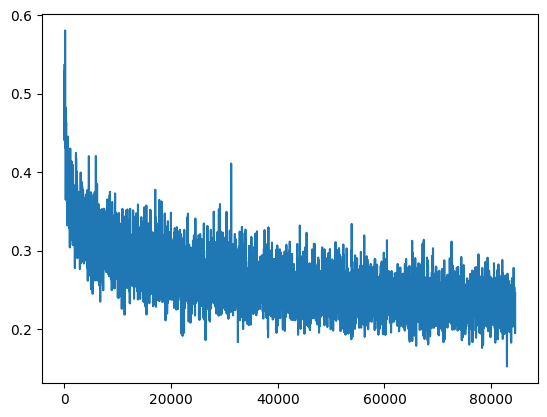

In [19]:
# import plotly
# import plotly.express as px
# import plotly.graph_objects as go
import matplotlib.pyplot as plt

# fig = go.Figure()
plt.plot(counter, gen_pixel_losses)

plt.show()

Using next(iter(_)) we obtain a tensor with dimension (batch_size, num_channels, size, size)

## Here we will do data preprocessing with our data